# Valhalla/OSRM Routing APIs load test

The route-calculation service developed at eClever aims to find the best strategy for an electric vehicle to drive from a starting location A to a destination B, with corresponding required charge stops in between. This process requires the collection of various data like vehicle and user information, tariffs, among others. 

One piece of data which is rather important is routing data such as information on how to drive from point A to B and time/distance matrices. This data is requested from specialized routing APIs like Valhalla. Currently, the route-calculation service used the [Open Route Service API](https://openrouteservice.org/) for this purpose. In the near feature this requests will be done using other APIs namely [OSRM](http://project-osrm.org/) and [Valhalla](https://gis-ops.com/de/routing-and-optimisation/valhalla/). 

Now, in order to test the overall performance of the route-calculation service under stress, it is first important to understand what is the performance of its individual elements. In this notebook we aim to perform load tests on these routing APIs (OSRM and Valhalla) in order to check how they behave under high requests load. This will allow us to identify and understand the limits of these APIs and their contribution to the overall performance of the service. 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Strategy" data-toc-modified-id="Strategy-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Strategy</a></span><ul class="toc-item"><li><span><a href="#Resources" data-toc-modified-id="Resources-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Resources</a></span></li></ul></li><li><span><a href="#Metrics" data-toc-modified-id="Metrics-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Metrics</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#A-to-B-requests." data-toc-modified-id="A-to-B-requests.-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>A to B requests.</a></span></li><li><span><a href="#Matrix-requests." data-toc-modified-id="Matrix-requests.-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Matrix requests.</a></span></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Summary</a></span></li></ul></div>

## Strategy

For the performance tests we will do what is known as a ramp up test. Here we set up a number of concurrent (parallel) users that will be sending requests to the API during a period of time. More precisely, we will start with 15 virtual users sending requests during 3 minutes. After this time is over, we increase the amount of concurrent users by additional 15 and hold again for 3 minutes. We keep doing this until we reach 300 concurrent users. The whole test lasts 60 minutes.

These tests where ran using the package [siege](https://www.joedog.org/), with the following setup:

`siege --concurrent=N --time=3M -d1 -f 'test_urls.txt --internet`

Where N is the number of concurrent users. The file *test_urls.txt* contains a set of about 500 different requests generated using a vast combination of origin, destinations. The *--internet* parameter is used in conjunction with the *test_urls.txt* file, this causes each user to randomly hit one of the URLs, with no predetermined pattern similar to real life conditions.

Ramp test are also meant to simulate cases where there are peak hours where the web traffic is increased, so switch from a state where there very few requests to a peak state where many users are sending requests.

The ramp up request will be done on both routing APIs (OSRM and Valhalla). For each API we will perform two load tests for the different type of requests, namely A to B and matrix requests. The A to B request are simple route request from a location A to another one B. On the other hand, matrix request are those where we request a time/distance matrix between multiple locations.

### Resources
Both OSRM and Valhalla APIs are running on the same Strato server sharing 32 CPUs und 134.8 Gb RAM.

## Metrics

To analyze the effect of the ramp up test, the following metrics will be considered:
+ **Response time:** Average time (seconds) it took to respond to each simulated user’s requests.  
+ **Transaction rate:** Average number of transactions the server was able to handle per second.
+ **Concurrency:** It is defined as the sum of all transaction times divided by the total elapsed time (3 min). That tells us the average number of simultaneous connections.
+ **Availability:** Percentage from the total requests that the server was able to process.

The table below shows an excerpt of the data from Valhalla A to B load test.

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

def read_data(filename):
    file = f'siege/{filename}/data.csv'
    data = pd.read_csv(file)
    return data

#load data
osrm_ab = read_data("osrm_a_to_b_load_test")
osrm_ab["API"] = "osrm"
osrm_matrix = read_data("osrm_matrix_load_test")
osrm_matrix["API"] = "osrm"
valhalla_ab = read_data("valhalla_a_to_b_load_test")
valhalla_ab["API"] = "valhalla"
valhalla_matrix = read_data("valhalla_matrix_load_test")
valhalla_matrix["API"] = "valhalla"

valhalla_ab.head()

Date & Time  Trans  Elap Time  Data Trans  Resp Time  Trans Rate  \
0  2023-01-06 18:36:56   3190     180.00         122       0.34       17.72   
1  2023-01-06 18:39:56   6592     179.91         249       0.31       36.64   
2  2023-01-06 18:42:56  10082     179.91         382       0.30       56.04   
3  2023-01-06 18:45:56  13417     179.92         510       0.30       74.57   
4  2023-01-06 18:48:56  16220     179.91         618       0.32       90.16   

   Throughput  Concurrent   OKAY  Failed    Time  Availability  users  \
0        0.68        5.98   3188       3  180.00     99.905986     15   
1        1.38       11.26   6586      25  359.91     99.621842     30   
2        2.12       16.54  10071      32  539.82     99.683262     45   
3        2.83       22.32  13406      32  719.74     99.761869     60   
4        3.44       29.05  16196     265  899.65     98.390134     75   

        API  
0  valhalla  
1  valhalla  
2  valhalla  
3  valhalla  
4  valhalla

## Results

The figure below shows an example of how the ramp up test is performed. The figure shows the time evolution of the ramp up test for the Valhalla A to B requests. The blue line shows the amount of users which are being constantly increased. The red line, in contrast, shows the variation of the transaction rate. As can be seen for the first 20 minutes it increases from 0 to 100 transactions, then in saturates at 100 trans./sec an stays constant at this value for the rest of the time.

By comparing both lines we can clearly see that transaction rate saturates when the amount of users is about 105. Which means that the API is able to handle up to 100 users without a problem, however, if more users are present the server is able to process only 100 transactions per second. 

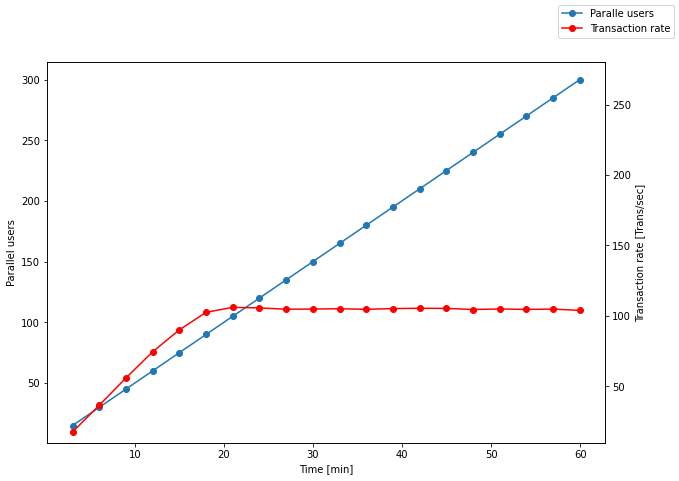

In [63]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax2 = ax1.twinx()
ax1.plot(valhalla_ab["Time"]/60, valhalla_ab["users"], "o-", label="Paralle users")
ax2.plot(valhalla_ab["Time"]/60, valhalla_ab["Trans Rate"], "o-", label="Transaction rate", color="red")
ax1.set_ylabel("Parallel users")
ax1.set_xlabel("Time [min]")
ax2.set_ylabel("Transaction rate [Trans/sec]")
ax2.set_ylim(10,280)

fig.legend();

The figure above was just a visual representation of how the ramp test is performed, however more useful for us will be to directly plot the above discussed metrics as a function of the amount of parallel virtual users.

### A to B requests.

The figure below shows exactly that, it depicts the evolution of the metrics as function of the number of parallel users. The figure below shows these metrics obtained for the A to B request for both OSRM (blue) and Valhalla (orange). 

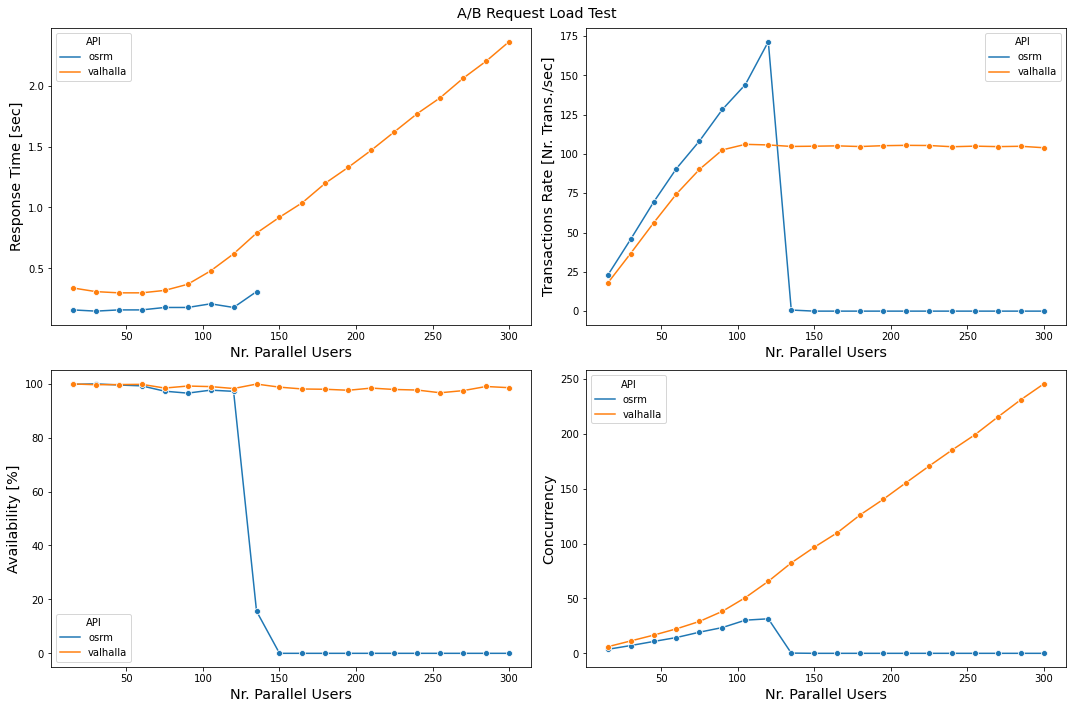

In [74]:
def plot_metric_seaborn(df, title):
    cols = ["Resp Time", "Trans Rate", "Availability", "Concurrent"]
    cols_dict = {
        "Resp Time": "Response Time [sec]",
        "Trans Rate": "Transactions Rate [Nr. Trans./sec]",
        "Availability": "Availability [%]",
        "Concurrent": "Concurrency"
        
    }
    fig = plt.figure(figsize=(15,10))
    for i, col in enumerate(cols):
        ax = fig.add_subplot(2,2,i+1)
#         ax.plot(df["users"], df[col], "-o")
        ax.set_ylabel(cols_dict[col],fontsize="x-large")
        ax.set_xlabel("Nr. Parallel Users", fontsize="x-large")
        sb.lineplot(data=df, x="users", y=col, marker="o", hue="API", ax=ax)
    plt.suptitle(title,fontsize="x-large")
    plt.tight_layout()

ab_data = pd.concat([osrm_ab, valhalla_ab])
ab_data["Resp Time"] = pd.to_numeric(ab_data["Resp Time"], errors="coerce")
ab_data = ab_data.reset_index(drop=True)

plot_metric_seaborn(ab_data, "A/B Request Load Test")

The upper left figure shows the response time as a function of parallel virtual users. As observed, the response time for both API is about constant from 0 to 100 users. In this range we see also that the response time for the OSRM (0.17 sec) API is shorter than with Valhalla (0.34 sec), this means that OSRM in this range returns a request response faster than Valhalla. In fact the response time for Valhalla is twice that of OSRM. 

Increasing the amount of users above 100, increases the response time of the Valhalla API linearly so that when the amount of users is 300 the response time is about 2.3 seconds.

On the other hand, we see for OSRM that above 120 users there are no more data points. This is because the load on the server was too high and it was brought down.

Regarding transaction rate (upper right fig.), we see that this increases by increasing the amount of users. Below 120 users the transaction rate is larger for OSRM, meaning that the API can process more requests than Valhalla (about 50% more requests at 100 parallel users). As early discussed we see that the transaction rate for Valhalla saturates to about 100 Trans./sec at about 95 users but the server stays alive, in contrast to OSRM which is brought down when the amount of users reaches 120.

Turning to the availability (fig. lower left), we see that it is almost 100% for both API, except for the case where the OSRM API is down above 120 users.

The concurrency (fig. lower right), shows also that for the case where the number of users is lower than 100, OSRM performs better since the concurrency is lower. Although, once the number of users is larger than 120 the concurrency constantly increases for Valhalla, but it still alive, which is not the case for OSRM.

So as a first conclusion for the A to B request, we can say that for the case where the number of parallel users is below 100, OSRM performs much better than Valhalla, the response times are about half, the transaction rate is larger (more requests per second) and the concurrency is lower. in this range, we can say that he Valhalla API performs decently. Once the amount of parallel users goes above 110-120 the Valhalla API performance starts to decrease but at least it stays alive. On the contrary the OSRM API was brought down and it was not able to handle any more request.

### Matrix requests.

Let us now check the results of the load test for the Matrix request which are shown in the figure below.

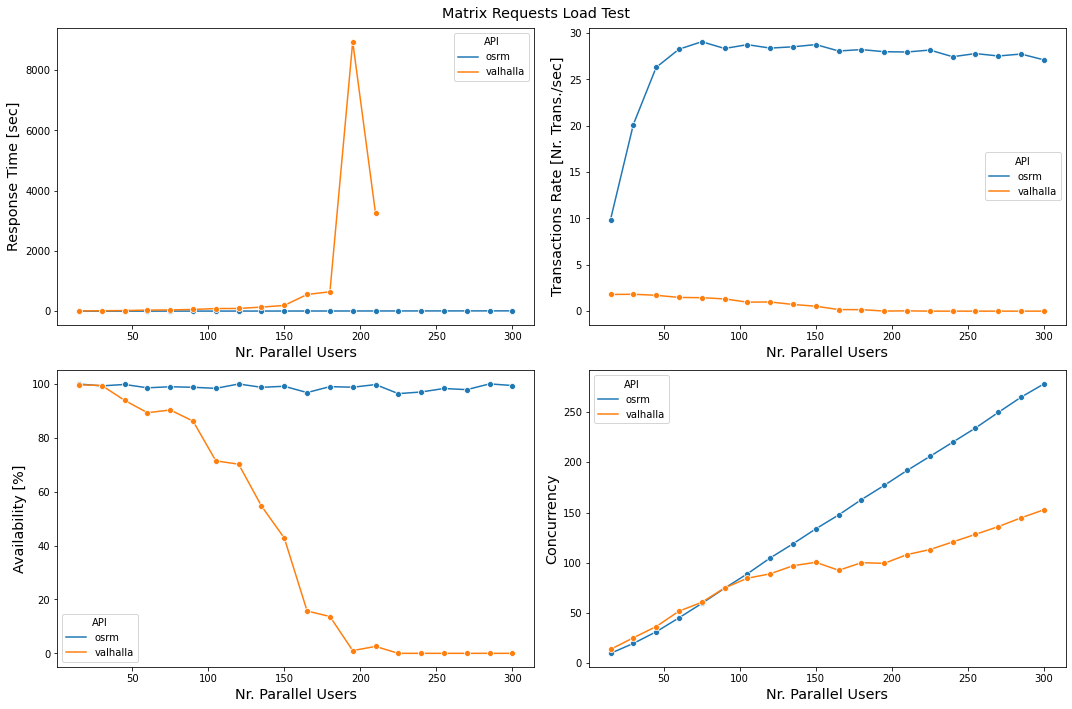

In [95]:
matrix_data = pd.concat([osrm_matrix, valhalla_matrix])
matrix_data["Resp Time"] = pd.to_numeric(matrix_data["Resp Time"], errors="coerce")
matrix_data = matrix_data.reset_index(drop=True)

plot_metric_seaborn(matrix_data, "Matrix Requests Load Test")

Starting with the response time (fig. upper left) we see that, overall, the response time from OSRM API (blue) is always lower than that of Valhalla (orange) for matrix requests. The figure below shows again the same plot of response time vs. nr. of Parallel users, but showing the region for times below 50 seconds. Here we can clearly see that OSRM response time increases steadily upon increasing the amount of users, however, the response time stays below the 10 seconds mark. For Valhalla, the response time explodes quite rapidly so for 90 users, this is above the 60 seconds mark. Actually, upon further increase of users, above 180 users the server is down and no more requests can be processed.

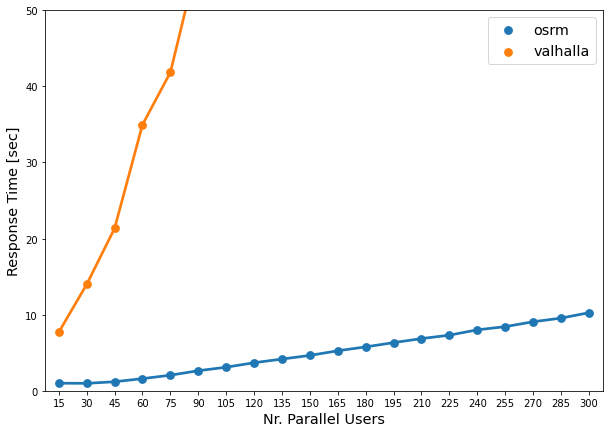

In [105]:
plt.figure(figsize=(10,7))
sb.pointplot(data=matrix_data, x="users", y="Resp Time", hue="API")
plt.ylabel("Response Time [sec]",fontsize="x-large")
plt.xlabel("Nr. Parallel Users",fontsize="x-large")
plt.legend(fontsize="x-large")
plt.ylim(0, 50);

Let us now consider the transactions rate (upper left fig.). We see for OSRM that the transaction rate increases with the amount of parallel users. When the number of users reaches about 60, the transaction rate saturates to a value of 28 Trans./sec. Valhalla, on the other hand, decreases the transaction rate upon increasing users and finally drops to zero at 180 users. Also, rather important is that, the transaction rate of Valhalla is really low, below 3 transactions per second, which is very slow.

The availability (lower right fig.) shows for OSRM a value of about 100% during the whole test, meaning that all request where processed. In contrast, Valhalla's availability rapidly drops upon increasing the amount of parallel users.

Finally, concurrency (lower right fig.) shows for the OSRM API a constant increase upon increasing the number of users. Valhalla shows also an increase of concurrency similar to that of OSRM. Although, once the number of parallel users reaches 100, concurrency goes down for Valhalla, whereas for OSRM it keeps increasing.

Regarding concurrency, one has to be careful, since for siege the definition of concurrency is the sum of all request times divided by the total elapsed time (3 minutes in our case), when we compare the two APIs, if one is lower it means that it performs better, because it takes less time to process a given amount of transaction in the 3 minutes time window used during the test. This is true if both APIs behave similarly in terms of availability and transaction rate, which is not the case here. As observed, the availability is much lower for Valhalla, also the transaction rate is about 10 times lower. This means, that the sum of all transaction times is smaller but also the number of transactions is lower. Let us take as an example the case where there was 90 concurrent users, for Valhalla the total amount of processed transaction was 272 and concurrency was 75. For OSRM concurrency was 74.7 but the total number of transactions was 5098. So for Valhalla the sum of all transaction times was the same as for OSRM, even though, OSRM processed almost 20 more requests.

To conclude this section we can then say that, for the matrix requests, OSRM performs much better than Valhalla. The response time is always below the 10 seconds, whereas for Valhalla, this value exploits quickly up to minutes upon increasing the number of concurrent users. Transaction rate for OSRM increases with the amount of users and saturates to a value of 28 Trans./sec when there are 60 parallel users. Valhalla in this case shows a steadily drop of transaction rate meaning that there are less processed transaction by increasing users.

Availability is almost 100% for OSRM throughout the whole test, while it rapidly drops for Valhalla above 50 users.

## Summary

The results of the load test for our routing APIs OSRM and Valhalla has shown that similarly than [previous comparative studies](https://eclever.atlassian.net/wiki/spaces/DEV/pages/3210510337/Routing+API+comparison+2+Valhalla+vs.+OSRM+vs.+OpenRouteService) on these APIs. OSRM shows a better performance than Valhalla specially regarding the Response times and transaction rates. However, we see that the server show some limitations. We have seen, for instance, that OSRM performs well during A to B requests, so far the number of parallel users is below 110, then the server goes down. Valhalla stays alive but the response times increase linearly.

Matrix request on the other hand, show also that, response time, transaction rate and availability are better for OSRM than for Valhalla. For Valhalla the response rate is always several times larger than that from OSRM and also the availability quickly drops upon increasing the amount of concurrent users. However, the transaction rate for OSRM saturates at a value of 28 trans./sec for users above 90. This means that in principle OSRM is able to decently handle about 90 parallel users. Larger amount of users induce a performance decrease. This also applies to Valhalla, although comparing the two of them OSRM show better metric values.

**Links**
+ https://www.euperia.com/wrote/speed-testing-your-website-with-siege-part-one
+ http://blog.modsaid.com/2014/04/stress-testing-with-siege-and-bombard.html
+ https://loadfocus.com/docs/guides/load-testing
+ https://loadfocus.com/load-testing
+ https://www.interserver.net/tips/kb/http-load-testing-siege/
+ https://www.joedog.org/siege-faq/#a13

In [115]:
import re
import os

def read_session_res(file_name):
    with open(file_name, 'r') as f:
        timestamp =[]
        resp = []
        time = []
        for line in f:
            entry = line.split()
            timestamp.append('{} {}'.format(entry[1], entry[2][:-1]))
            resp.append(int(entry[4]))
            time.append(float(entry[5]))

    return pd.DataFrame({'timestamp':timestamp, 'response':resp, 'time':time})

def get_stats_session(filename):
    all_stats = pd.DataFrame()
    files = os.listdir(filename)
    files = [f for f in files if f.split(".")[1] =="txt"]

    for file in files:
        concurrent = int(re.findall("(\d+)",file)[0])
        data_df = read_session_res(f"{filename}/{file}")
        stats = data_df.describe().time
        stats['concurrent'] = concurrent
        all_stats = pd.concat([all_stats, stats], axis=1)
        
    return (
            all_stats.T
            .reset_index(drop=True)
            .set_index("concurrent")
            .sort_index()
        )

_ = get_stats_session("siege/valhalla_a_to_b_load_test/")
_

count      mean       std   min     25%   50%   75%    max
concurrent                                                              
15.0         3190.0  0.337483  0.631992  0.12  0.2200  0.25  0.29   5.48
30.0         6592.0  0.307371  0.547335  0.11  0.2100  0.24  0.28   5.46
45.0        10082.0  0.295072  0.525511  0.12  0.2000  0.23  0.27   5.46
60.0        13417.0  0.299324  0.521770  0.11  0.2000  0.23  0.28   5.58
75.0        16220.0  0.322216  0.528593  0.10  0.2200  0.26  0.30   5.69
90.0        18454.0  0.373136  0.480385  0.10  0.2600  0.32  0.38   5.66
105.0       19092.0  0.478358  0.504190  0.14  0.3500  0.42  0.50   5.76
120.0       19022.0  0.620320  0.530551  0.18  0.4700  0.56  0.66   5.98
135.0       18847.0  0.786240  0.529760  0.20  0.5500  0.70  0.91   6.39
150.0       18875.0  0.920831  0.584315  0.23  0.6100  0.83  1.10   6.87
165.0       18915.0  1.044156  0.573095  0.20  0.7400  0.96  1.26   6.96
180.0       18840.0  1.204313  0.413800  0.21  1.0200  1.15  1.33   6.71
195.0       18938.0  1.331607  0.453817  0.18  1.1400  1.33  1.51   6.84
210.0       18976.0  1.473571  0.648634  0.22  1.1500  1.39  1.65   7.78
225.0       18956.0  1.618061  0.647750  0.22  1.2275  1.55  1.92   8.03
240.0       18815.0  1.769893  0.645796  0.27  1.4000  1.66  1.96   8.34
255.0       18881.0  1.896989  0.797411  0.19  1.4400  1.74  2.19  10.31
270.0       18830.0  2.056911  0.682426  0.21  1.6700  1.95  2.26   8.58
285.0       18866.0  2.202766  1.005462  0.17  1.5000  1.86  2.76  11.20
300.0       18700.0  2.361142  0.920947  0.20  1.8000  2.25  2.83  11.14